### 第一题

#### 题目

房价预测

#### 解答

##### 导入依赖

In [1]:
import pandas
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

##### 读取数据

In [2]:

#读取csv数据
train_data = pandas.read_csv("kaggle_house_pred_train.csv")
test_data = pandas.read_csv("kaggle_house_pred_test.csv")
#把去掉id的数据拼在一起，去掉id的目的是为了防止模型通过记住编号得到对应房价。
all_features = pandas.concat(( train_data.iloc[:,1:-1], test_data.iloc[:,1:]))
print("train_data.shape:",train_data.shape)
print("test_data.shape:",test_data.shape)
print("all_features:",all_features.shape)
print(train_data.iloc[:5,:8])

train_data.shape: (1460, 81)
test_data.shape: (1459, 80)
all_features: (2919, 79)
   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape
0   1          60       RL         65.0     8450   Pave   NaN      Reg
1   2          20       RL         80.0     9600   Pave   NaN      Reg
2   3          60       RL         68.0    11250   Pave   NaN      IR1
3   4          70       RL         60.0     9550   Pave   NaN      IR1
4   5          60       RL         84.0    14260   Pave   NaN      IR1


##### 处理缺省值和属性

In [3]:
#提取全是数字的特征名字
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
#对数据做标准化处理,对应位置赋值
all_features[numeric_features] = all_features[numeric_features].apply(lambda x: (x - x.mean()) / (x.
std()))
# 在标准化数据之后，将缺失值设置为0
all_features[numeric_features] = all_features[numeric_features].fillna(0)
#‘Dummy_na=True‘ 将“na”（缺失值）视为有效的特征值，并为其创建指示符特征。
# pandas.get_dummies把特征为类别值或离散值分成每一个特征为一个类别。
all_features = pandas.get_dummies(all_features, dummy_na = True)
print("all_features.shape:",all_features.shape)
all_features.head()

all_features.shape: (2919, 331)


,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_Oth,SaleType_WD,SaleType_nan,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SaleCondition_nan
0,0.067320,-0.184443,-0.217841,0.646073,-0.507197,1.046078,0.896679,0.523038,0.580708,-0.29303,...,0,1,0,0,0,0,0,1,0,0
1,-0.873466,0.458096,-0.072032,-0.063174,2.187904,0.154737,-0.395536,-0.569893,1.177709,-0.29303,...,0,1,0,0,0,0,0,1,0,0
2,0.067320,-0.055935,0.137173,0.646073,-0.507197,0.980053,0.848819,0.333448,0.097840,-0.29303,...,0,1,0,0,0,0,0,1,0,0
3,0.302516,-0.398622,-0.078371,0.646073,-0.507197,-1.859033,-0.682695,-0.569893,-0.494771,-0.29303,...,0,1,0,1,0,0,0,0,0,0
4,0.067320,0.629439,0.518814,1.355319,-0.507197,0.947040,0.753100,1.381770,0.468770,-0.29303,...,0,1,0,0,0,0,0,1,0,0


##### 分成训练数据和测试数据

In [4]:
#把数据分成训练数据和测试数据
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype = torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype = torch.float32)
train_labels = torch.tensor(train_data.SalePrice.values.reshape(-1, 1), dtype = torch.float32)
print("train_features.shape:", train_features.shape)
print("train_features.shape:", test_features.shape)
print("train_labels:", train_labels.shape)

train_features.shape: torch.Size([1460, 331])
train_features.shape: torch.Size([1459, 331])
train_labels: torch.Size([1460, 1])


##### 数据分批

In [5]:
batch_size = 32

dataset = torch.utils.data.TensorDataset(train_features, train_labels)

train_loader = torch.utils.data.DataLoader(dataset, # 数据
    batch_size = batch_size, # 每个batch大小
    shuffle = True, # 是否打乱数据
    num_workers = 0, # 工作线程
    pin_memory = True)

print(f"每一批{len(next(iter(train_loader))[0])}个，一共{len(train_loader)}批")

#for X, y in train_loader:
#    print(X.shape, y.shape)

每一批32个，一共46批


##### 定义网络

In [6]:
class Net(nn.Module):
  
    def __init__(self, features):
        super(Net, self).__init__()
        
        self.linear_relu1 = nn.Linear(features, 512)
        self.linear_relu2 = nn.Linear(512, 512)
        self.linear_relu3 = nn.Linear(512, 256)
        self.linear_relu4 = nn.Linear(256, 256)
        self.linear5 = nn.Linear(256, 1)
        
    def forward(self, x):
        
        y_pred = self.linear_relu1(x)
        y_pred = nn.functional.relu(y_pred)
        
        y_pred = self.linear_relu2(y_pred)
        y_pred = nn.functional.relu(y_pred)
        
        y_pred = self.linear_relu3(y_pred)
        y_pred = nn.functional.relu(y_pred)
        
        y_pred = self.linear_relu4(y_pred)
        y_pred = nn.functional.relu(y_pred)
        
        y_pred = self.linear5(y_pred)
        return y_pred

model = Net(features=train_features.shape[1])



##### 使用GPU设备并将模型放到GPU上

In [7]:
def try_gpu(i=0):  #尝试获取gpu设备
    """如果存在，则返回gpu(i)，否则返回cpu()"""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

model = model.to(device=try_gpu())

##### 初始化神经网络

注意损失函数的计算函数也应放到GPU上

In [8]:
#初始化参数
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
        nn.init.zeros_(m.bias)

model.apply(init_weights);

# 使用均方误差作为损失函数
criterion = nn.MSELoss(reduction='mean').to(try_gpu())

#优化算法选择Adam算法
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

losses = []
#animator = d2l.Animator(xlabel='epoch', xlim=[1, 500], ylim=[0.0, 1.0],legend=['train loss'])


##### 定义loss图像绘图函数

In [9]:
from IPython import display
class Animator: #@save
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
    ylim=None, xscale='linear', yscale='linear',
    fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
    figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

##### 训练神经网络并绘图

After 0 epoches, loss = 195481.32404891305
After 10 epoches, loss = 24050.718070652172
After 20 epoches, loss = 22454.165251358696
After 30 epoches, loss = 21402.586489470108
After 40 epoches, loss = 20285.055642832882
After 50 epoches, loss = 19577.549443783966
After 60 epoches, loss = 18414.095915421196
After 70 epoches, loss = 17704.975755774456
After 80 epoches, loss = 16883.78560207201
After 90 epoches, loss = 15942.197966202446
After 100 epoches, loss = 15030.859502377718
After 110 epoches, loss = 13655.88716457201
After 120 epoches, loss = 12169.264988111414
After 130 epoches, loss = 11715.843866762907
After 140 epoches, loss = 10086.368132218071
After 150 epoches, loss = 9358.478876528532
After 160 epoches, loss = 8147.374087126359
After 170 epoches, loss = 7451.373620074728
After 180 epoches, loss = 6687.9590215268345
After 190 epoches, loss = 5926.6917724609375
After 200 epoches, loss = 5461.700460682745
After 210 epoches, loss = 4588.0909423828125
After 220 epoches, loss = 4

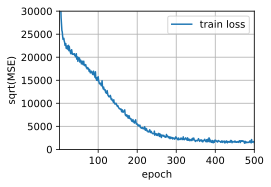

In [10]:
# 训练500epoch
num_epochs=500

animator = Animator(xlabel='epoch',ylabel='sqrt(MSE)', xlim=[1, num_epochs], ylim=[0, 30000],
    legend=['train loss'])

for epoch in range(0,num_epochs):
    train_loss=0;
    for X, y in train_loader: 
        X, y = X.to(device=try_gpu()), y.to(device=try_gpu())
        y_pred = model(X)

        loss=torch.sqrt(criterion(y_pred,y))# 为此处选择标准差作为损失函数，更能看出误差相较于真实值的比例
        #print(t, loss.item())
        train_loss+=loss.item()

        if torch.isnan(loss):
            break
        
        # 将模型中各参数的梯度清零。
        # PyTorch的backward()方法计算梯度会默认将本次计算的梯度与缓存中已有的梯度加和。
        # 必须在反向传播前先清零。
        optimizer.zero_grad()
        
        # 反向传播，计算各参数对于损失loss的梯度
        loss.backward()
        
        # 根据刚刚反向传播得到的梯度更新模型参数
        optimizer.step()
    
    animator.add(epoch + 1, train_loss/len(train_loader))

    if(epoch%10==0):
        losses.append(train_loss/len(train_loader))
        #print(epoch,train_loss/len(train_loader))

for i in range(0,num_epochs//10):
    print(f"After {i*10} epoches, loss = {losses[i]}")

##### 测试神经网络生成提交数据

In [11]:
def test(model,test_features):
    test_features = test_features.to(device=try_gpu())
    preds = model(test_features).detach().to("cpu").numpy()
    print(preds.squeeze().shape)

    #pandas.Series 创建新维度
    test_data['SalePrice'] = pandas.Series(preds.squeeze())
              
    #axis选择拼接的维度
    return pandas.concat([test_data['Id'], test_data['SalePrice']], axis = 1)

submission = test(model,test_features)
submission.to_csv('submission.csv', index=False)

(1459,)
